In [38]:
import os, os.path
import cv2
import random
from sklearn import decomposition
import matplotlib.pyplot as plt
import numpy as np



surprise_path = "../Lab1/Cohn-Kanade/surprise/"
happy_path = "../Lab1/Cohn-Kanade/happy/"

surprise_imgs = []
happy_imgs = []

images = os.listdir(surprise_path)
for img_num, img in enumerate(images):
    surprise_imgs.append(cv2.cvtColor(cv2.imread(surprise_path + '/' + img), cv2.COLOR_BGR2GRAY))

images = os.listdir(happy_path)
for img_num, img in enumerate(images):
    happy_imgs.append(cv2.cvtColor(cv2.imread(happy_path + '/' + img), cv2.COLOR_BGR2GRAY))

random.shuffle(surprise_imgs)
random.shuffle(happy_imgs)


X_train = surprise_imgs[:50] + happy_imgs[:50]
X_test = surprise_imgs[50:] + happy_imgs[50:]
y_train = [0] * 50 + [1] * 50
y_test = [0] * (len(surprise_imgs)-50) + [1] * (len(happy_imgs)-50)


twoD_to_vec = lambda mat: mat.reshape(-1).T
X_train_vectorized = list(map(twoD_to_vec, X_train))
X_test_vectorized = list(map(twoD_to_vec, X_test))


pca = decomposition.PCA(n_components=50)

X_train_pca = pca.fit_transform(X_train_vectorized)
X_test_pca = pca.transform(X_test_vectorized)


(1, 50)


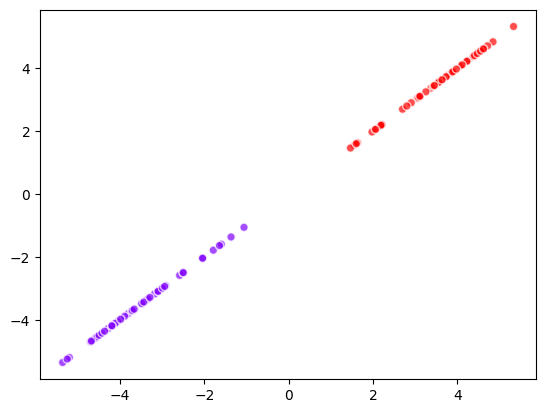

In [39]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


lda = LinearDiscriminantAnalysis()
X_train_pca_lda = lda.fit_transform(X_train_pca, y_train)
X_test_pca_lda = lda.transform(X_test_pca)

scale_norm = lda.scalings_/(sum(lda.scalings_**2))**0.5

plt.scatter(
    X_train_pca_lda[:,0],X_train_pca_lda[:,0],c=y_train,cmap='rainbow',
  alpha=0.7,edgecolors='w'
)
print(scale_norm.T.shape)

(1, 600, 300)


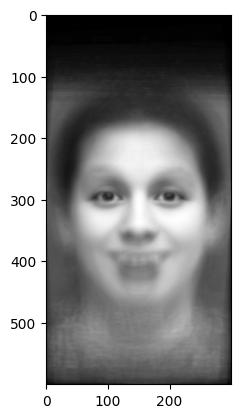

In [40]:
reconstraced_pca = pca.inverse_transform(scale_norm.T)
reconstraced_img = reconstraced_pca.reshape(reconstraced_pca.shape[0], X_train[0].shape[0], X_train[0].shape[1])
plt.imshow(reconstraced_img[0], cmap = 'gray')
print(reconstraced_img.shape)

نتیجه پرینت شده در سل قبل و دو سل قبل، اندازه نتایج تبدیل «ال-دی-ای» و تبدیل وارون آن برای تبدیل به تصویر عادی است.
که هر دو نشان دهنده این است که نتیجه «ال-دی-ای» تنها دارای یک بردار ویژه است. این مطابق انتظار است چرا که کلا دو کلاس از داده ها در دسترس بوده است.

در تصویر هم واضح است که عمدتا قسمت های تیره مربوط به نواحی است که در حالت «سورپرایز» نسبت به حالت «خوشحال» بیشترین تفاوت را دارد. در نتیجه این 
تفاوت، واریانس داده در این نواحی بیشتر است و میدانیم که بردار فیشر، عمود بر جهتی است که واریانس در آن بیشینه است بنابراین این نواحی مقدار عددی کمتر 
و در نتیجه تیرگی بیشتر دارند.

در نقطه مقابل، قسمت های روشن نواحی هستند که در هر دو کلاس داده شباهت و نزدیکی زیادی دارند و دارای واریانس کم هستند و در بردار بدست آمده از فیشر 
باقی میمانند. 




In [47]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

svc_model = SVC()

Train_acc_knn1 = []
Test_acc_knn1 = []
Train_acc_knn3 = []
Test_acc_knn3 = []
Train_acc_knn5 = []
Test_acc_knn5 = []

Train_acc_lda = []
Test_acc_lda  = []

for n_c in range(5,50,5):
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train_vectorized)
    X_test = scaler.transform(X_test_vectorized)

    pca = decomposition.PCA(n_components = n_c)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)

    lda = LinearDiscriminantAnalysis()
    X_train_pca_lda = lda.fit_transform(X_train_pca, y_train)
    X_test_pca_lda = lda.transform(X_test_pca)

    svc_model.fit(X_train_pca_lda, y_train)

    y_train_lda_pred = svc_model.predict(X_train_pca_lda)
    y_test_lda_pred = svc_model.predict(X_test_pca_lda)
    
    train_acc_lda = 100*(1 - sum(abs(y_train - y_train_lda_pred))/len(y_train))
    test_acc_lda  = 100*(1 - sum(abs(y_test - y_test_lda_pred))/len(y_test))

    est = KNeighborsClassifier(n_neighbors = 1)
    est.fit(X_train_pca, y_train)
    y_train_knn1_pred = est.predict(X_train_pca)
    y_test_knn1_pred = est.predict(X_test_pca)
    train_acc_knn1 = 100*(1 - sum(abs(y_train - y_train_knn1_pred))/len(y_train))
    test_acc_knn1  = 100*(1 - sum(abs(y_test - y_test_knn1_pred))/len(y_test))

    est = KNeighborsClassifier(n_neighbors = 3)
    est.fit(X_train_pca, y_train)
    y_train_knn3_pred = est.predict(X_train_pca)
    y_test_knn3_pred = est.predict(X_test_pca)
    train_acc_knn3 = 100*(1 - sum(abs(y_train - y_train_knn3_pred))/len(y_train))
    test_acc_knn3  = 100*(1 - sum(abs(y_test - y_test_knn3_pred))/len(y_test))

    est = KNeighborsClassifier(n_neighbors = 5)
    est.fit(X_train_pca, y_train)
    y_train_knn5_pred = est.predict(X_train_pca)
    y_test_knn5_pred = est.predict(X_test_pca)
    train_acc_knn5 = 100*(1 - sum(abs(y_train - y_train_knn5_pred))/len(y_train))
    test_acc_knn5  = 100*(1 - sum(abs(y_test - y_test_knn5_pred))/len(y_test))

    print(f"for n_components = {n_c}:   Train_lda={train_acc_lda:.{3}f}%   Test_lda={test_acc_lda:.{3}f}%   Train_knn1={train_acc_knn1:.{3}f}%   Test_knn1={test_acc_knn1:.{3}f}%   Train_knn3={train_acc_knn3:.{3}f}%   Test_knn3={test_acc_knn3:.{3}f}%   Train_knn5={train_acc_knn5:.{3}f}%   Test_knn5={test_acc_knn5:.{3}f}%")
    Train_acc_lda.append(train_acc_lda)
    Test_acc_lda.append(test_acc_lda)
    Train_acc_knn1.append(train_acc_knn1)
    Test_acc_knn1.append(test_acc_knn1)
    Train_acc_knn3.append(train_acc_knn3)
    Test_acc_knn3.append(test_acc_knn3)
    Train_acc_knn5.append(train_acc_knn5)
    Test_acc_knn5.append(test_acc_knn5)


    


for n_components = 5:   Train_lda=62.000%   Test_lda=53.425%   Train_knn1=100.000%   Test_knn1=34.247%   Train_knn3=73.000%   Test_knn3=36.986%   Train_knn5=69.000%   Test_knn5=39.726%
for n_components = 10:   Train_lda=89.000%   Test_lda=83.562%   Train_knn1=100.000%   Test_knn1=43.836%   Train_knn3=88.000%   Test_knn3=63.014%   Train_knn5=84.000%   Test_knn5=69.863%
for n_components = 15:   Train_lda=97.000%   Test_lda=94.521%   Train_knn1=100.000%   Test_knn1=47.945%   Train_knn3=87.000%   Test_knn3=61.644%   Train_knn5=87.000%   Test_knn5=72.603%
for n_components = 20:   Train_lda=98.000%   Test_lda=95.890%   Train_knn1=100.000%   Test_knn1=42.466%   Train_knn3=85.000%   Test_knn3=69.863%   Train_knn5=90.000%   Test_knn5=75.342%
for n_components = 25:   Train_lda=100.000%   Test_lda=97.260%   Train_knn1=100.000%   Test_knn1=43.836%   Train_knn3=86.000%   Test_knn3=69.863%   Train_knn5=86.000%   Test_knn5=75.342%
for n_components = 30:   Train_lda=100.000%   Test_lda=100.000%   Trai

واضح است که با افزایش کامپوننت های «پی-سی-ای» دقت مدل هم در داده های آموزش هم در داده های تست افزایش میابد تا جایی که حتی به صد در صد هم میرسید. اما در مقابل، دقت «کی-ان-ان» از مقداری به بعد به قولی اشباع میشود و درصد دقت پایین تری نسبت به «ال-دی-ای» همواره دارد..

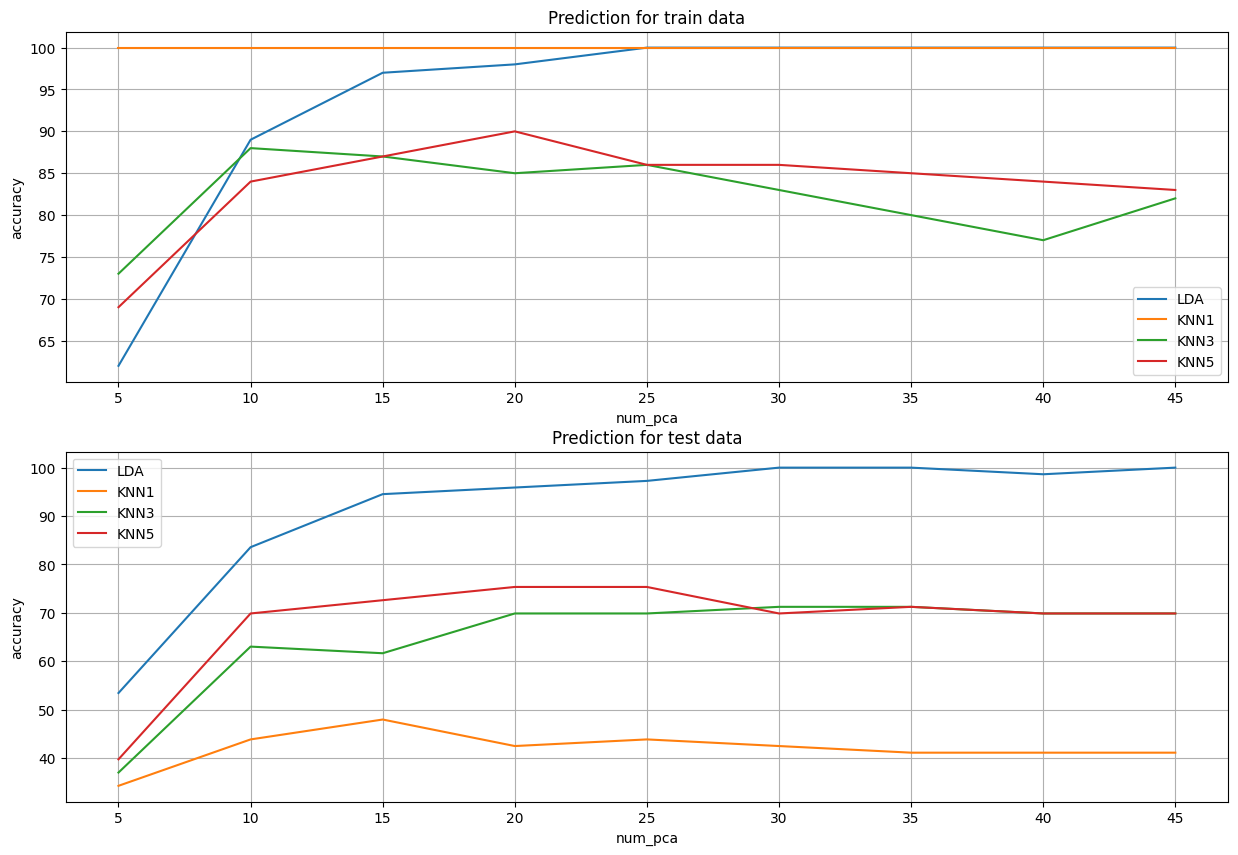

In [50]:
plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(range(5,50,5),Train_acc_lda)
plt.plot(range(5,50,5),Train_acc_knn1)
plt.plot(range(5,50,5),Train_acc_knn3)
plt.plot(range(5,50,5),Train_acc_knn5)
plt.title("Prediction for train data")
plt.legend(["LDA","KNN1","KNN3","KNN5"])
plt.xlabel("num_pca")
plt.ylabel("accuracy")
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(range(5,50,5),Test_acc_lda)
plt.plot(range(5,50,5),Test_acc_knn1)
plt.plot(range(5,50,5),Test_acc_knn3)
plt.plot(range(5,50,5),Test_acc_knn5)
plt.title("Prediction for test data")
plt.legend(["LDA","KNN1","KNN3","KNN5"])
plt.xlabel("num_pca")
plt.ylabel("accuracy")
plt.grid(True)